Cleaning course data to be able to perform analysis on

In [1]:
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import plotly.express as px
from db.connection import *
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import json
from db.connection import *


In [63]:
def clean_course(course):
    """
    Cleans a single course entry.
    """
    # Normalize text fields
    course["description"] = course.get("description", "").capitalize().strip()
    course["lecturer"] = course.get("lecturer", "").replace("Professor, ", "").strip()
    course["math_difficulty"] = course.get("math_difficulty", "").capitalize()
    course["math_level"] = course.get("math_level", "").replace("Very high", "High")
    
    # Convert numerical fields
    if "credit" in course:
        course["credit"] = int(course["credit"]) if course["credit"].isdigit() else None
    if "leacture_duration" in course:
        course["lecture_duration"] = int(course["lecture_duration"]) if course["lecture_duration"].isdigit() else None
    if "self_study_hours" in course:
        course["self_study_hours"] = int(course["self_study_hours"]) if course["self_study_hours"].isdigit() else None

    # Normalize boolean fields
    if "with_course_videos" in course:
        course["with_course_videos"] = course["with_course_videos"].lower() == "yes"
    
    # Return cleaned course
    return course

def clean_courses(file_path, output_path):
    """
    Reads a JSON file with courses, cleans each course, and saves the cleaned data to a new file.
    """
    try:
        # Load the JSON file
        with open(file_path, "r", encoding="utf-8") as file:
            courses = json.load(file)
        
        # Clean each course
        cleaned_courses = [clean_course(course) for course in courses]

        # Save the cleaned courses to a new file
        with open(output_path, "w", encoding="utf-8") as file:
            json.dump(cleaned_courses, file, indent=4, ensure_ascii=False)

        print(f"Cleaned courses saved to {output_path}")
    except Exception as e:
        print(f"An error occurred: {e}")


In [135]:
# #clean courses
# input_file = 'model/files/courses.json'
# output_file = 'model/files/cleaned_courses.json'
# processed_file = 'model/files/processed_courses.json'

# clean_courses(input_file, output_file)


In [136]:
#feature engineering

def extract_course_concepts(courses, num_concepts=20):
    """
    Extracts top keywords from course descriptions using TF-IDF.
    """
    descriptions = [course["description"] for course in courses]

    # Apply TF-IDF vectorization
    vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(descriptions)
    feature_names = vectorizer.get_feature_names_out()

    # Extract top keywords for each course
    for i, course in enumerate(courses):
        tfidf_scores = tfidf_matrix[i].toarray()[0]
        top_indices = tfidf_scores.argsort()[-num_concepts:][::-1]
        top_concepts = [feature_names[idx] for idx in top_indices]
        course["core_concepts"] = top_concepts

    return courses

def encode_categorical_features(courses, categorical_fields, ordinal_cat_fields):
    """
    Encodes categorical features as sets for Jaccard similarity.
    """
    # One-hot encode categorical variables
    encoder = OneHotEncoder()
    ordinal_encoder = OrdinalEncoder()
   
    categorical_data = pd.DataFrame(courses)[categorical_fields]
    ordinal_cat_data = pd.DataFrame(courses)[ordinal_cat_fields]
    encoded_features = encoder.fit_transform(categorical_data)
    ordinal_encoded_features = ordinal_encoder.fit_transform(ordinal_cat_data)

    # Update courses with scaled values
    for i, course in enumerate(courses):
        for j, field in enumerate(categorical_fields):
            course[field] = encoded_features[i, j]
        for j, field in enumerate(ordinal_cat_fields):
            course[field] = ordinal_encoded_features[i, j]
    return courses

def scale_numerical_features(courses, numerical_fields):
    """
    Scales numerical features using Min-Max Scaling.
    """
    scaler = MinMaxScaler()
    numerical_data = pd.DataFrame(courses)[numerical_fields]
    scaled_data = scaler.fit_transform(numerical_data)

    # Update courses with scaled values
    for i, course in enumerate(courses):
        for j, field in enumerate(numerical_fields):
            course[field] = scaled_data[i, j]
    return courses

def convert_sets_to_lists(courses):
    """
    Converts all sets in the course data to lists for JSON serialization.
    """
    for course in courses:
        for key, value in course.items():
            if isinstance(value, set):
                course[key] = list(value)
    return courses


def feature_engineering_pipeline(courses):
    """
    Full feature engineering pipeline for courses.
    """
    # Step 1: Extract course concepts
    courses = extract_course_concepts(courses)

    # Step 2: Encode categorical features
    categorical_fields = ["teaching_style", "exam_type", "module", 'language']
    ordinal_cat_fields = ["exam_difficulty", "math_level"]
    courses = encode_categorical_features(courses, categorical_fields, ordinal_cat_fields)

    # # Step 3: Scale numerical features
    numerical_fields = ["credit", "lecture_duration", "self_study_hours"]
    courses = scale_numerical_features(courses, numerical_fields)

    return courses



In [137]:
# #feature engineering and storing courses in diff file
# # Load cleaned data
# with open(processed_file, "r", encoding="utf-8") as file:
#     courses = json.load(file)

# # Apply feature engineering pipeline
# processed_courses = feature_engineering_pipeline(courses)

# # Convert sets to lists for JSON compatibility
# processed_courses = convert_sets_to_lists(processed_courses)

# # Save processed data
# with open("files/processed_courses.json", "w", encoding="utf-8") as file:
#     json.dump(processed_courses, file, indent=4, ensure_ascii=False)

# print("Feature engineering completed and saved!")


In [138]:

# # Load JSON data from a file
# with open(processed_courses, 'r') as file:
#     data = json.load(file)

# # Convert JSON data to DataFrame
# df = pd.json_normalize(data)

# # Set the index to course id
# df.set_index('Course_ID', inplace=True)

# # Display the first 5 records
# print(df.head())

In [139]:
# # Load JSON data from a file
# with open(input_file, 'r') as file:
#     data = json.load(file)

# with open(processed_file, 'r') as file:
#     processed_data = json.load(file)

# # Replace extracted concepts in 'processed_data' with core concepts from 'data'
# for course in processed_data:
#     # Find the corresponding entry from 'data' by matching course id
#     entry = next((item for item in data if item['Course_ID'] == course['Course_ID']), None)
    
#     # If a matching entry is found, update the 'Extracted_Concepts'
#     if entry:
#         course['Extracted_Concepts'] = entry['Course_Core_Concept']


# # Save the updated 'processed_data' to a file
# with open(processed_file, "w", encoding="utf-8") as file:
#     json.dump(processed_data, file, indent=4)



In [64]:
# fetch dataa
courses_data = fetch_data('processed_courses')

df = pd.DataFrame(courses_data)

print(df.head(1))

Pinged your deployment. You successfully connected to MongoDB!
                        _id Course_ID               Course_Name  \
0  67755b588cd78ea1d39b7a3d  ZKD50032  Advanced Image Synthesis   

                                  Course_Description            Term  \
0  Abstract:\nThis lecture covers the fundamental...  Winter 2024/25   

   Course_Language              Course_Teacher  Course_Credit  \
0                0  Professor, Dr. Jens Krüger              0   

   With_Course_Videos  Course_Teaching_Style  ...  Course_Exam_Type  \
0                True                      1  ...                 1   

   Course_Required_Math_Level  Course_Recommended_Background  \
0                           4            [Computer graphics]   

                       Programming_Requirements Course_Class_Hours  \
0  [{'Language': 'C++', 'Level': 'proficient'}]                0.5   

   Homework_mandatorily required_hours  Course_Module  \
0                                  0.0              1   

In [65]:
# One-hot encoding concepts
df = pd.DataFrame(courses_data)

df["core_concepts"] = df["core_concepts"].apply(lambda x: ",".join(x))  # Join list of concepts into a string
concepts_array = df[["core_concepts"]]  # Convert to DataFrame with single column

encoder = OneHotEncoder()
concept_matrix = encoder.fit_transform(concepts_array).toarray()

# Reduce dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(concept_matrix)

# Create a DataFrame
df_reduced = pd.DataFrame(reduced_data, columns=["x", "y"])
df_reduced["id"] = df["id"]

# Plot clustering
fig = px.scatter(
    df_reduced, 
    x="x", 
    y="y", 
    text="id",
    size_max=200,
    title="Course Clustering based on Extracted Concepts"
)


# Update the font size specifically for the text labels
fig.update_traces(
    textfont=dict(
        family="Courier New, monospace",
        size=7,  # Set the desired font size
        color="red"  # Optional: Change text color
    ),
    marker=dict(size=10)
)

fig.show()


In [66]:
# Create DataFrame
df = pd.DataFrame(courses_data)
# print(df.count())

# Bubble chart
fig = px.scatter(
    df, 
    x="exam_difficulty", 
    y="math_level", 
    size="math_level", 
    color="exam_difficulty",
    title="Module Comparison: Math Level vs Difficulty"
)
fig.show()

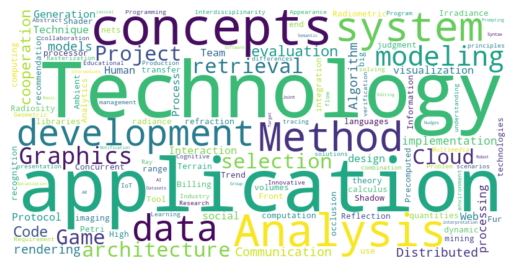

In [56]:

#word cloud
concepts = []
all = []

for course in courses_data:
    concepts.append(course['core_concepts'])

flattened_concepts = [", ".join(course) for course in concepts]

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(flattened_concepts))

# Display with matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [57]:
fig = px.bar(df, x="lecturer", title="Number of Courses by Teacher")
fig.show()

In [58]:

# Count occurrences of each module
module_counts = df["encoded_module"].value_counts().reset_index()
module_counts.columns = ["Module", "Count"]
print(f"Count of 'Modules' in 'Courses': {module_counts}")

fig = px.pie(
    module_counts,
    names="Module",
    values="Count",
    title="Distribution of Modules",
    color_discrete_sequence=px.colors.qualitative.Pastel1
)

fig.show()

Count of 'Modules' in 'Courses':                                   Module  Count
0  Interactive Systems and Visualization      8
1          Intelligent Networked Systems      6
2                                 Basics      4


In [59]:
# Count occurrences of each module
language_counts = df["encoded_language"].value_counts().reset_index()
language_counts.columns = ["Language", "Count"]
print(f"Count of 'Languages' in 'Courses': {language_counts}")

fig = px.pie(
    language_counts,
    names="Language",
    values="Count",
    title="Distribution of Languages",
    color_discrete_sequence=px.colors.qualitative.Pastel1
)

fig.show()

Count of 'Languages' in 'Courses':   Language  Count
0  English     13
1   German      5


In [60]:
# Define the mapping of numerical values to their string labels
teaching_style_labels = {
    0.0: "Course+Exercise+Project",
    1.0: "Course+Exercise",
    2.0: "Course+Project"
}

# Replace the numerical values with string labels in the 'Course_Teaching_Style' column
df["teaching_style_label"] = df["teaching_style"].replace(teaching_style_labels)

# Get the updated counts with labels
teaching_style_counts = df["teaching_style_label"].value_counts().reset_index()
teaching_style_counts.columns = ["Style", "Count"]

# Print the updated counts
print(f"Count of 'Teaching Styles' in 'Courses':\n{teaching_style_counts}")

fig = px.pie(
    teaching_style_counts,
    names="Style",
    values="Count",
    title="Distribution of Course Teaching Styles",
    color_discrete_sequence=px.colors.qualitative.Pastel1
)

fig.show()

Count of 'Teaching Styles' in 'Courses':
                     Style  Count
0          Course+Exercise     11
1           Course+Project      5
2  Course+Exercise+Project      2


In [ ]:
# # Load JSON data from a file
# with open(input_file, 'r') as file:
#     data = json.load(file)

# with open(processed_file, 'r') as file:
#     processed_data = json.load(file)

# # Replace extracted concepts in 'processed_data' with core concepts from 'data'
# for course in processed_data:
#     # Find the corresponding entry from 'data' by matching course id
#     entry = next((item for item in data if item['Course_ID'] == course['Course_ID']), None)
    
#     # If a matching entry is found, update the 'Extracted_Concepts'
#     if entry:
#         course['Extracted_Concepts'] = entry['Course_Core_Concept']


# # Save the updated 'processed_data' to a file
# with open(processed_file, "w", encoding="utf-8") as file:
#     json.dump(processed_data, file, indent=4)



In [ ]:
# Convert data to DataFrame

# Group and count courses by Encoded_Module and Term
heatmap_data = df.groupby(["encoded_module", "semester"]).size().reset_index(name="count")

# Pivot the data to create a matrix
heatmap_matrix = heatmap_data.pivot(index="encoded_module", columns="semester", values="count").fillna(0)

# Draw Heatmap using Plotly
fig = px.imshow(
    heatmap_matrix,
    labels=dict(x="semester", y="encoded_module", color="count"),
    x=heatmap_matrix.columns,
    y=heatmap_matrix.index,
    color_continuous_scale="Viridis", 
    title="Course Distribution by Module and Term",
)

# Show the heatmap
fig.show()

In [ ]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import plotly.graph_objects as go

# Example data
students = [{
    "Student_ID": "3200056",
    "interest":"logic",
    "student_professional_background": ["computer graphics"],
    "Student_Math_Background": [
        {"Subject_Name": "Calculous", "Level": "proficient"},
        {"Subject_Name": "Linear_Algebra", "Level": "qualified"},
        {"Subject_Name": "Possibility", "Level": "basic"}
    ],
    "Student_Programming_Level": [
        {"Language": "Java", "Level": "basic"},
        {"Language": "C++", "Level": "basic"}
    ],
    "Student_Language_Level": [
        {"Language ": "German", "Level": "basic"},
        {"Language ": "English", "Level": "fluent"}
    ],
    "Available_Exercise_Time_Per_Week": 10
}]

courses = [{
    "name": "Logic",
    "core_concepts": [
        "Propositional logic", "First-order predicate logic", "Logical concepts"
    ],
    "math_level": "low",
    "self_study_hours": 8,
    "language": "German",
    "with_videos": "Yes",
    "exam_difficulty": "easy",
    "lecture_duration": 4,
    "required_programming": {"Language": "Java", "Level": "basic"}
},
{
    "name": "Fundamentals of Technical Informatics",
    "core_concepts": [
        "Boolean algebra", "Digital circuits", "Binary coding"
    ],
    "math_level": "low",
    "self_study_hours": 5,
    "language": "German",
    "with_videos": "Yes",
    "exam_difficulty": "easy",
    "lecture_duration": 3,
    "required_programming": {"Language": "C++", "Level": "qualified"}
}]

# Data preprocessing
def preprocess_texts(courses, students):
    course_docs = [
        ' '.join(course.get('core_concepts', ['general']) + [course.get('description', '')])
        for course in courses
    ]
    student_docs = [
        ' '.join([str(item) for item in student['student_professional_background']] + [student['interest']])
        for student in students
    ]
    return course_docs, student_docs

course_docs, student_docs = preprocess_texts(courses, students)

# TF-IDF model
dictionary = Dictionary([doc.split() for doc in course_docs + student_docs])
corpus = [dictionary.doc2bow(doc.split()) for doc in course_docs + student_docs]
tfidf = TfidfModel(corpus)
index = MatrixSimilarity(tfidf[corpus])

# Similarity calculation
def calculate_similarity(course_docs, student_docs, index, tfidf, dictionary):
    similarities = []
    for student_doc in student_docs:
        student_vec = tfidf[dictionary.doc2bow(student_doc.split())]
        sims = index[student_vec]
        similarities.append(sims[:len(course_docs)])
    return np.array(similarities)

similarity_matrix = calculate_similarity(course_docs, student_docs, index, tfidf, dictionary)

# Time matching
def time_match(student_time, course):
    total_course_time = course['self_study_hours'] + course['lecture_duration']
    return min(1.0, student_time / total_course_time)

# Language matching
def language_match(student_languages, course_language):
    for lang in student_languages:
        if lang['Language '].strip() == course_language:
            if lang['Level'].strip() in ['native', 'fluent']:
                return 1.0
            elif lang['Level'].strip() in ['proficient']:
                return 0.8
            elif lang['Level'].strip() in ['basic']:
                return 0.5
    return 0.0

# Programming language matching
def programming_match(student_programming, course_programming):
    for prog in student_programming:
        if prog['Language'] == course_programming['Language']:
            levels = {"basic": 1, "qualified": 2, "proficient": 3, "advanced": 4}
            student_level = levels.get(prog['Level'], 0)
            course_level = levels.get(course_programming['Level'], 0)
            return min(1.0, student_level / course_level) if course_level > 0 else 0.0
    return 0.0

# Math level matching
def math_match(student_math, course_math):
    levels = {"basic": 1, "qualified": 2, "proficient": 3, "excellent": 4}
    student_level = max([levels.get(math['Level'], 0) for math in student_math], default=0)
    course_level = levels.get(course_math, 0)
    if student_level >= course_level:
        return 1.0  # Meets or exceeds the requirement
    return student_level / course_level if course_level > 0 else 0.0

# Overall score calculation (Content similarity split into parts)
def calculate_scores(similarity_matrix, students, courses):
    scores = []
    for i, student in enumerate(students):
        student_time = student['Available_Exercise_Time_Per_Week']
        student_languages = student['Student_Language_Level']
        student_programming = student['Student_Programming_Level']
        student_math = student['Student_Math_Background']
        student_scores = []
        for j, course in enumerate(courses):
            # Subscores
            time_score = time_match(student_time, course)
            content_similarity = similarity_matrix[i, j]
            math_score = math_match(student_math, course['math_level'])
            language_score = language_match(student_languages, course['language'])
            programming_score = programming_match(student_programming, course.get('required_programming', {}))

            # Final score with weights
            final_score = (
                0.3 * content_similarity +
                0.2 * math_score +
                0.2 * time_score +
                0.15 * language_score +
                0.15 * programming_score
            )
            student_scores.append((course['name'], final_score, {
                'Content Similarity': content_similarity,
                'Math Match': math_score,
                'Time Match': time_score,
                'Language Match': language_score,
                'Programming Match': programming_score
            }))
        scores.append(sorted(student_scores, key=lambda x: x[1], reverse=True))
    return scores

# Calculate final recommendation results
scores = calculate_scores(similarity_matrix, students, courses)
print("Recommendation Results (with language and programming match):", scores)

# Visualize top recommended course breakdown
def plot_top_course_radar(scores, students, courses):
    top_course = scores[0][0]  # Get the top course for the first student
    top_course_name = top_course[0]
    top_course_details = top_course[2]

    # Radar chart data
    categories = list(top_course_details.keys())
    values = list(top_course_details.values())
    values.append(values[0])  # Close the radar chart

    # Draw radar chart
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories + [categories[0]],  # Close
        fill='toself',
        name=top_course_name
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )
        ),
        title=f"Recommendation Breakdown for {top_course_name} "
    )

    fig.show()

# Call radar chart function
plot_top_course_radar(scores, students, courses)
